# Text Classification


In [32]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizer

#### A First Look at Hugging Face Datasets
link: https://github.com/huggingface/datasets

In [33]:
# load the emotion dataset with the load_dataset() function:
emotions = load_dataset("emotion")
emotions

No config specified, defaulting to: emotion/split
Found cached dataset emotion (C:/Users/andsfonseca/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [34]:
# we can use the usual dictionary syntax to access an individual split:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [35]:
print("Length: ", len(train_ds))
print("Column names:", train_ds.column_names)
print("Values: ", train_ds.features)
print("Access a single example by its index:", train_ds[0])

Length:  16000
Column names: ['text', 'label']
Values:  {'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}
Access a single example by its index: {'text': 'i didnt feel humiliated', 'label': 0}


#### From Datasets to DataFrames


In [36]:
emotions.set_format(type="pandas")

In [37]:
df_train = emotions["train"][:]

df_train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [38]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df_train["label_name"] = df_train["label"].apply(label_int2str)

df_train.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


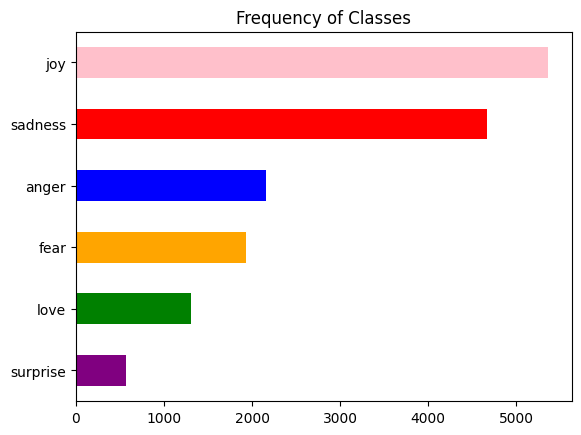

In [39]:
df_train["label_name"].value_counts(ascending=True).plot.barh(color={"red", "green", "pink", "blue", "orange", "purple"})
plt.title("Frequency of Classes")
plt.show()

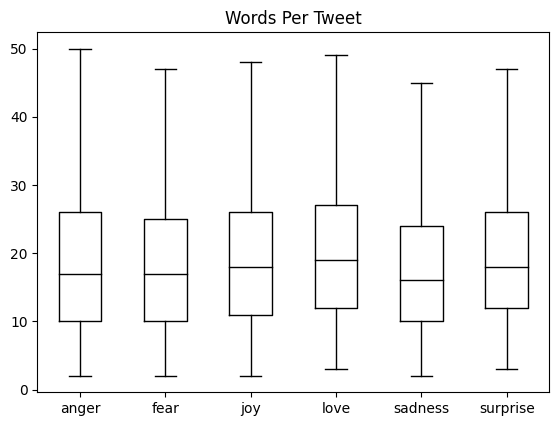

In [40]:
df_train["Words Per Tweet"] = df_train["text"].str.split().apply(len)
df_train.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [41]:
emotions.reset_format()

### From Text to Tokens


#### Character Tokenization

In [42]:
example_text = df_train["text"][31]
example_text

'i remember feeling acutely distressed for a few days'

In [43]:
tokenized_example_text = list(example_text)
print(tokenized_example_text)

['i', ' ', 'r', 'e', 'm', 'e', 'm', 'b', 'e', 'r', ' ', 'f', 'e', 'e', 'l', 'i', 'n', 'g', ' ', 'a', 'c', 'u', 't', 'e', 'l', 'y', ' ', 'd', 'i', 's', 't', 'r', 'e', 's', 's', 'e', 'd', ' ', 'f', 'o', 'r', ' ', 'a', ' ', 'f', 'e', 'w', ' ', 'd', 'a', 'y', 's']


In [44]:
token2id_example = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_example_text)))}
print(token2id_example)

{' ': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'i': 8, 'l': 9, 'm': 10, 'n': 11, 'o': 12, 'r': 13, 's': 14, 't': 15, 'u': 16, 'w': 17, 'y': 18}


In [45]:
tokenized_example_ids = [token2id_example[token] for token in tokenized_example_text]
print(tokenized_example_ids)

[8, 0, 13, 5, 10, 5, 10, 2, 5, 13, 0, 6, 5, 5, 9, 8, 11, 7, 0, 1, 3, 16, 15, 5, 9, 18, 0, 4, 8, 14, 15, 13, 5, 14, 14, 5, 4, 0, 6, 12, 13, 0, 1, 0, 6, 5, 17, 0, 4, 1, 18, 14]


<hr style="height:2px;border:none;background-color:gray;"></hr>

##### One-hot vectors

In [46]:
categorical_df = pd.DataFrame(
 {"Name": ["Melão", "Melancia", "Laranja", "Melão"], "Label ID": [0,1,2,0]})
categorical_df

,Name,Label ID
0,Melão,0
1,Melancia,1
2,Laranja,2
3,Melão,0


In [47]:
pd.get_dummies(categorical_df["Name"])

,Laranja,Melancia,Melão
0,0,0,1
1,0,1,0
2,1,0,0
3,0,0,1


<hr style="height:2px;border:none;background-color:gray;"></hr>

In [48]:
input_ids = torch.tensor(tokenized_example_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2id_example))
one_hot_encodings.shape

torch.Size([52, 19])

In [49]:
print(f"Token: {tokenized_example_text[0]}")
print(f"Tensor index: {tokenized_example_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: i
Tensor index: 8
One-hot: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenization

In [50]:
tokenized_word_example_text = example_text.split()
tokenized_word_example_text

['i',
 'remember',
 'feeling',
 'acutely',
 'distressed',
 'for',
 'a',
 'few',
 'days']

In [51]:
token2id_word_example = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_word_example_text)))}
print(token2id_word_example)

{'a': 0, 'acutely': 1, 'days': 2, 'distressed': 3, 'feeling': 4, 'few': 5, 'for': 6, 'i': 7, 'remember': 8}


In [52]:
tokenized_word_example_ids = [token2id_word_example[token] for token in tokenized_word_example_text]
print(tokenized_word_example_ids)

[7, 8, 4, 1, 3, 6, 0, 5, 2]


In [53]:
input_ids = torch.tensor(tokenized_word_example_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2id_word_example))
print(f"Token: {tokenized_word_example_text[2]}")
print(f"Tensor index: {tokenized_word_example_ids[2]}")
print(f"One-hot: {one_hot_encodings[2]}")

Token: feeling
Tensor index: 4
One-hot: tensor([0, 0, 0, 0, 1, 0, 0, 0, 0])


#### Subword Tokenization

In [54]:
model_ckpt = "distilbert-base-uncased"
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [55]:
# gerando os tokens usando Distilbert Tokenizer
encoded_text = distilbert_tokenizer(example_text)

print(example_text)
print(encoded_text["input_ids"])

i remember feeling acutely distressed for a few days
[101, 1045, 3342, 3110, 11325, 2135, 24305, 2005, 1037, 2261, 2420, 102]


In [56]:
# vendo os tokens
tokens = distilbert_tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'i',
 'remember',
 'feeling',
 'acute',
 '##ly',
 'distressed',
 'for',
 'a',
 'few',
 'days',
 '[SEP]']

In [57]:
# convertendo os tokens para texto
distilbert_tokenizer.convert_tokens_to_string(tokens)

'[CLS] i remember feeling acutely distressed for a few days [SEP]'

In [58]:
# tamanho do vocabulário
distilbert_tokenizer.vocab_size

30522

In [59]:
# tamanho máximo do contexto
distilbert_tokenizer.model_max_length

512

In [60]:
# nomes dos campos que o modelo espera
distilbert_tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing the Whole Dataset

In [61]:
def tokenize(batch):
    return distilbert_tokenizer(batch["text"], padding=True, truncation=True)

In [67]:
print(tokenize(emotions["train"][:2])["input_ids"])

[[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]]


|   Special Token  | [PAD] | [UNK] | [CLS] | [SEP] | [MASK] |
|:----------------:|:-----:|:-----:|:-----:|:-----:|:------:|
| Special Token ID |   0   |  100  |  101  |  102  |   103  |

In [68]:
tokens = distilbert_tokenizer.convert_ids_to_tokens(tokenize(emotions["train"][:2])["input_ids"][0])
tokens

['[CLS]',
 'i',
 'didn',
 '##t',
 'feel',
 'humiliated',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [70]:
# aplicando em todo o dataset a função tokenizadora
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-d89dd4898f20b378.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-4d1075bc28cae21d.arrow
Loading cached processed dataset at C:\Users\andsfonseca\.cache\huggingface\datasets\emotion\split\1.0.0\cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd\cache-99b3a0590e833797.arrow


In [86]:
for i in range(1):
    row = emotions_encoded["train"][i]  
    print(row["text"]) 
    print(row["input_ids"]) 


i didnt feel humiliated
[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
